# Introduction

In this notebook I attempt to debug my mesh solver by having it solve a problem which I have created such that I know the exact solution.

In particular, I want to solve my Mesh PDE for the solution
$$ x(\xi, \eta) = \frac{\xi + \xi^2}{2} \text{ and } y(\xi, \eta) = \eta $$
given the Mesh Density Function
$$ M = \begin{bmatrix}
x_{\xi} & 0 \\
0 & y_{\eta}
\end{bmatrix} = \begin{bmatrix}
1/2 + \xi & 0 \\
0 & 1
\end{bmatrix} $$

To have a better understanding of the Mesh PDE, check out equations (3.8), (3.9), and (6.131) in the HR book!

# Results

From this notebook we learn that excluding/dividing out the 1/|J| in the mesh PDE is what is needed for better results!

# Imports

In [ ]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Mesh Solver (derived using matrices/vectors)

In [ ]:
# mesh solver


def mesh_solver(xi, eta, x, V, deg = 1, Neumann = False, Dirichlet = True, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # function to hold mesh solution
  mesh_sol = Function(V)

  # Jacobian

  J_matrix = grad(mesh_sol)
  detJ = det(J_matrix)

  # Mesh Density

  Mx = 1/2 + xi
  My = 1
  M_matrix = as_matrix([[1/Mx, 0], [0, 1/My]])

  # JMJ part

  # JMJ_matrix = dot(dot(transpose(J_matrix),M_matrix) , J_matrix)
  JMJ_matrix = transpose(J_matrix) * M_matrix * J_matrix
  JMJ_inv = inv(JMJ_matrix)



  # create problem

  # test function

  v = TestFunction(V)


  # Eqn

  F = inner(grad(v), detJ * JMJ_inv) * dx


  # The initial guess (current (x,y) mesh)

  mesh_sol.interpolate(as_vector([x[0], x[1]]))


  # the bc's


  if Neumann:

    bc1 = DirichletBC(V.sub(0), Constant(0), 1) # x=0 on left side
    bc2 = DirichletBC(V.sub(0), Constant(1), 2) # x=1 on right side
    bc3 = DirichletBC(V.sub(1), Constant(0), 3) # y=0 on bottom
    bc4 = DirichletBC(V.sub(1), Constant(1), 4) # y=1 on top
    bcs = [bc1, bc2, bc3, bc4]

  if Dirichlet:

    # bc1 = DirichletBC(V, as_vector([Constant(0), eta]), 1)  # x=0 on left side
    # bc2 = DirichletBC(V, as_vector([Constant(1), eta]), 2) # x=1 on right side
    # bc3 = DirichletBC(V, as_vector([xi**2, Constant(0)]), 3) # y=0 on bottom
    # bc4 = DirichletBC(V, as_vector([xi**2, Constant(1)]), 4) # y=1 on top
    # bcs = [bc1, bc2, bc3, bc4]

    xsolBC = (xi + xi**2)/2
    ysolBC = eta
    bcs = DirichletBC(V, as_vector([xsolBC, ysolBC]), 'on_boundary')





  # Solve, NewtonLS

  print("-"*125)
  print("Nonlinear Mesh Solve:")



  solve(F==0, mesh_sol, bcs = bcs, \
          solver_parameters = {'snes_converged_reason': None,\
                              'snes_monitor': None,\
                              "snes_stol": stol,\
                              "snes_rtol": rtol,\
                              "snes_atol": atol,\
                              "snes_max_it": maxit})

  print("-"*125)
  print()
  print()



 # evaluate the xy solution so I can plot it


  # solution data
  old_mesh_vals = mesh.coordinates.dat.data
  xsol = np.array(mesh_sol.at(old_mesh_vals))[:,0]
  ysol = np.array(mesh_sol.at(old_mesh_vals))[:,1]
  # create mesh
  initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
  nx = len(xsol)
  new_mesh_vals = np.zeros((nx, 2))
  new_mesh_vals[:,0] = xsol
  new_mesh_vals[:,1] = ysol
  initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals

  # # plot computational and physical mesh

  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # computational grid
  xi_plot = triplot(mesh, axes=axes[0])
  axes[0].set_title('Computational Grid')
  axes[0].set_xlabel(r"$\xi$")
  axes[0].set_ylabel(r"$\eta$")
  axes[0].set_aspect('equal')

  # physical grid
  x_plot = triplot(initial_phys_mesh, axes=axes[1])
  axes[1].set_title('Solution for x')
  axes[1].set_xlabel(r"$x$")
  axes[1].set_ylabel(r"$y$")
  axes[1].set_aspect('equal')

  plt.tight_layout()
  plt.show()

  print()
  print()


  # Just plot the contour plots

  CP = FunctionSpace(mesh, "CG", deg)

  fig, axes = plt.subplots(1, 2, figsize = (14, 6))
  xplt = tricontourf(Function(CP).interpolate(mesh_sol[0]), cmap = "seismic", axes = axes[1])
  eplt = tricontourf(Function(CP).interpolate(xi**2) , cmap = "seismic", axes = axes[0])
  plt.colorbar(xplt)
  plt.colorbar(eplt)
  axes[1].set_title("Computed x Solution")
  axes[0].set_title("Exact Solution")
  axes[0].set_aspect('equal')
  axes[1].set_aspect('equal')
  plt.tight_layout()
  plt.show()
  print()
  print()

  fig, axes = plt.subplots(1, 2, figsize = (14, 6))
  xplt = tricontourf(Function(CP).interpolate(mesh_sol[1]), cmap = "seismic", axes = axes[1])
  eplt = tricontourf(Function(CP).interpolate(eta) , cmap = "seismic", axes = axes[0])
  plt.colorbar(xplt)
  plt.colorbar(eplt)
  axes[1].set_title("Computed y Solution")
  axes[0].set_title("Exact Solution")
  axes[0].set_aspect('equal')
  axes[1].set_aspect('equal')
  plt.tight_layout()
  plt.show()
  print()
  print()


  return mesh_sol


# Mesh Solver (derived component wise)

In [ ]:
# mesh solver


def mesh_solver_componentwise(xi, eta, x, V, deg = 1, Neumann = False, Dirichlet = True, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # function to hold mesh solution
  mesh_sol = Function(V)
  # pull out x and y mesh solutions
  mesh_sol_x = mesh_sol[0]
  mesh_sol_y = mesh_sol[1]
  # gradient of x solution and y solution w.r.t (xi, eta)
  new_gradx = grad(mesh_sol_x)
  new_grady = grad(mesh_sol_y)
  # pull out terms of the gradients
  new_x_xi = new_gradx[0]
  new_x_eta = new_gradx[1]
  new_y_xi = new_grady[0]
  new_y_eta = new_grady[1]


  # jacobian

  new_det_J = new_x_xi * new_y_eta - new_x_eta * new_y_xi


  # a1 and a2 (these are the a^1 and a^2)

  a_1 = (1/new_det_J) * as_vector([new_y_eta, -new_x_eta])
  a_2 = (1/new_det_J) * as_vector([-new_y_xi, new_x_xi])


  # M matrix

  Mx = 1/2 + xi
  My = 1

  M = as_matrix([[Mx, 0], [0, My]])

  # problem vectors


  u1_0 = inner(new_det_J * a_1, dot(M, a_1))
  u1_1 = inner(new_det_J * a_2, dot(M, a_1))

  u2_0 = inner(new_det_J * a_1, dot(M, a_2))
  u2_1 = inner(new_det_J * a_2, dot(M, a_2))

  u1 = as_vector([u1_0, u1_1])
  u2 = as_vector([u2_0, u2_1])


  # create problem

  # test functions

  v = TestFunction(V)
  v1 = v[0]
  v2 = v[1]


  # # Eqn 1

  # a1 = (inner(u1, grad(v1/new_det_J)))


  # # Eqn 2

  # a2 = (inner(u2, grad(v2/new_det_J)))

  # Eqn 1

  a1 = (inner(u1, grad(v1)))


  # Eqn 2

  a2 = (inner(u2, grad(v2)))


  # The equation we solve , F==0

  F = (a1 + a2)*dx


  # The initial guess (current (x,y) mesh)

  mesh_sol.interpolate(as_vector([x[0], x[1]]))


  # the bc's

  if Neumann:

    bc1 = DirichletBC(V.sub(0), Constant(0), 1) # x=0 on left side
    bc2 = DirichletBC(V.sub(0), Constant(1), 2) # x=1 on right side
    bc3 = DirichletBC(V.sub(1), Constant(0), 3) # y=0 on bottom
    bc4 = DirichletBC(V.sub(1), Constant(1), 4) # y=1 on top
    bcs = [bc1, bc2, bc3, bc4]

  if Dirichlet:

    # bc1 = DirichletBC(V, as_vector([Constant(0), eta]), 1)  # x=0 on left side
    # bc2 = DirichletBC(V, as_vector([Constant(1), eta]), 2) # x=1 on right side
    # bc3 = DirichletBC(V, as_vector([(xi + xi**2)/2, Constant(0)]), 3) # y=0 on bottom
    # bc4 = DirichletBC(V, as_vector([(xi + xi**2)/2, Constant(1)]), 4) # y=1 on top
    # bcs = [bc1, bc2, bc3, bc4]

    xsolBC = (xi + xi**2)/2
    ysolBC = eta

    bcs = DirichletBC(V, as_vector([xsolBC, ysolBC]), 'on_boundary')


  # Solve, NewtonLS

  print("-"*125)
  print("Nonlinear Mesh Solve:")



  solve(F==0, mesh_sol, bcs = bcs, \
          solver_parameters = {'snes_converged_reason': None,\
                              'snes_monitor': None,\
                              "snes_stol": stol,\
                              "snes_rtol": rtol,\
                              "snes_atol": atol,\
                              "snes_max_it": maxit})

  print("-"*125)
  print()
  print()



  # evaluate the xy solution so I can plot it


  # solution data
  old_mesh_vals = mesh.coordinates.dat.data
  xsol = np.array(mesh_sol.at(old_mesh_vals))[:,0]
  ysol = np.array(mesh_sol.at(old_mesh_vals))[:,1]
  # create mesh
  initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
  nx = len(xsol)
  new_mesh_vals = np.zeros((nx, 2))
  new_mesh_vals[:,0] = xsol
  new_mesh_vals[:,1] = ysol
  initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals

  # # plot computational and physical mesh

  fig, axes = plt.subplots(1, 2, figsize=(14, 6))

  # computational grid
  xi_plot = triplot(mesh, axes=axes[0])
  axes[0].set_title('Computational Grid')
  axes[0].set_xlabel(r"$\xi$")
  axes[0].set_ylabel(r"$\eta$")
  axes[0].set_aspect('equal')

  # physical grid
  x_plot = triplot(initial_phys_mesh, axes=axes[1])
  axes[1].set_title('Solution for x')
  axes[1].set_xlabel(r"$x$")
  axes[1].set_ylabel(r"$y$")
  axes[1].set_aspect('equal')

  plt.tight_layout()
  plt.show()

  print()
  print()


  CP = FunctionSpace(mesh, "CG", deg)

  fig, axes = plt.subplots(1, 2, figsize = (14, 6))
  xplt = tricontourf(Function(CP).interpolate(mesh_sol[0]), cmap = "seismic", axes = axes[1])
  eplt = tricontourf(Function(CP).interpolate((xi + xi**2)/2) , cmap = "seismic", axes = axes[0])
  plt.colorbar(xplt)
  plt.colorbar(eplt)
  axes[1].set_title("Computed x Solution")
  axes[0].set_title("Exact Solution")
  axes[0].set_aspect('equal')
  axes[1].set_aspect('equal')
  plt.tight_layout()
  plt.show()
  print()
  print()

  fig, axes = plt.subplots(1, 2, figsize = (14, 6))
  xplt = tricontourf(Function(CP).interpolate(mesh_sol[1]), cmap = "seismic", axes = axes[1])
  eplt = tricontourf(Function(CP).interpolate(eta) , cmap = "seismic", axes = axes[0])
  plt.colorbar(xplt)
  plt.colorbar(eplt)
  axes[1].set_title("Computed y Solution")
  axes[0].set_title("Exact Solution")
  axes[0].set_aspect('equal')
  axes[1].set_aspect('equal')
  plt.tight_layout()
  plt.show()
  print()
  print()





  return mesh_sol


# The Test

N =  24
______________________________________________________________________________________________________________________________________________________




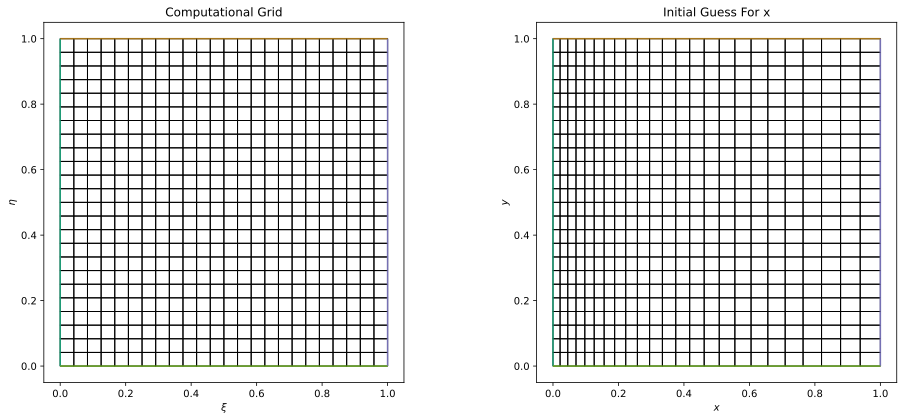



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 6.852388945529e-15
  1 SNES Function norm 7.497082534337e-15
  Nonlinear firedrake_3_ solve converged due to CONVERGED_SNORM_RELATIVE iterations 1
-----------------------------------------------------------------------------------------------------------------------------




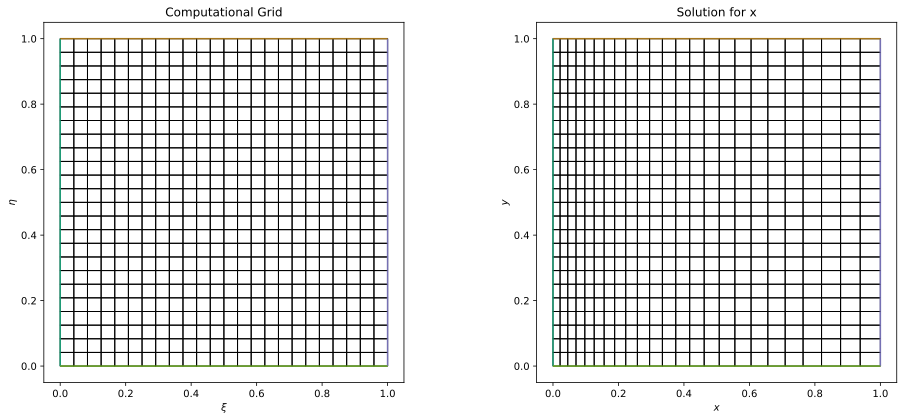

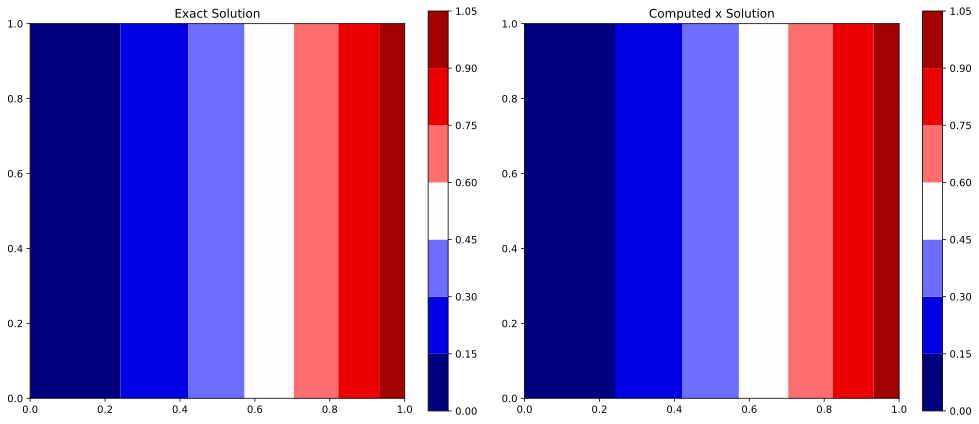

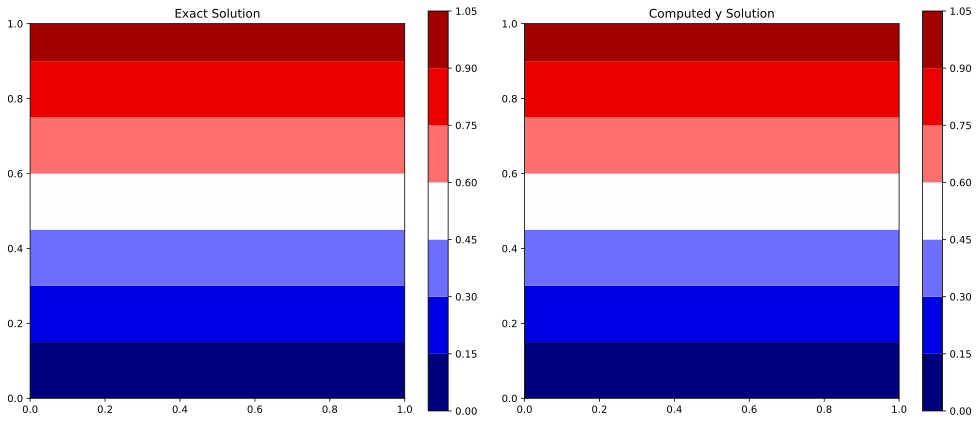



x error: 3.265706201858077e-16
y error: 3.842093409657106e-16


In [ ]:
# Set My Parameters

diagonal = "right"
quadrilateral = True
custom_cmap = "GnBu"
deg = 2 # degree of FEM for mesh solve
N = 24 # num of points
Neumann = True
Dirichlet = False

# SNES stopping criteria
stol = 1e-8
rtol = 1e-8
atol = 1e-50
maxit = 50

print("N = ", N)
print("_"*150)
print()
print()


# Set xi mesh (computational mesh)

mesh = UnitSquareMesh(N, N, quadrilateral = quadrilateral, diagonal = diagonal)

# function spaces
xi, eta = SpatialCoordinate(mesh)
W = FunctionSpace(mesh, "CG", deg)
V = VectorFunctionSpace(mesh, "CG", deg)

# set the initial guess for (x,y)

x = Function(V).interpolate(as_vector([(xi + xi**2)/2, eta]))


# evaluate our starting x function so that we can visualize

# solution data
old_mesh_vals = mesh.coordinates.dat.data
xsol = np.array(x.at(old_mesh_vals))[:,0]
ysol = np.array(x.at(old_mesh_vals))[:,1]

# create mesh
initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
nx = len(xsol)
new_mesh_vals = np.zeros((nx, 2))
new_mesh_vals[:,0] = xsol
new_mesh_vals[:,1] = ysol
initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals

# plot computational and physical mesh

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ccomputational grid
xi_plot = triplot(mesh, axes=axes[0])
axes[0].set_title('Computational Grid')
axes[0].set_xlabel(r"$\xi$")
axes[0].set_ylabel(r"$\eta$")
axes[0].set_aspect('equal')

# physical grid
x_plot = triplot(initial_phys_mesh, axes=axes[1])
axes[1].set_title('Initial Guess For x')
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print()
print()



# Mesh Solve

my_mesh_sol = mesh_solver_componentwise(xi, eta, x, V, deg = deg, Neumann = Neumann, Dirichlet = Dirichlet,\
                                rtol = rtol, stol = stol, atol = atol, maxit = maxit)

# my_mesh_sol = mesh_solver(xi, eta, x, V, deg = deg, Neumann = Neumann, Dirichlet = Dirichlet,\
#                                 rtol = rtol, stol = stol, atol = atol, maxit = maxit)



# error

xsol = my_mesh_sol[0]
ysol = my_mesh_sol[1]

x_error = norm(xsol - (xi+xi**2)/2)
y_error = norm(ysol - eta)

print("x error:", x_error)
print("y error:", y_error)






# Checking my Boundary Conditions

 ##  Print Out The Boundary Values of my Mesh Solution





In [ ]:
# pull out the boundaries of the mesh

xi0 = []
xi1 = []
eta0 = []
eta1 = []

meshvals = mesh.coordinates.dat.data

for i in meshvals:


  if i[0] == 0: # left boundary
    xi0.append(i)

  elif i[0] == 1: # right boundary
    xi1.append(i)

  if i[1] == 0: # bottom boundary
    eta0.append(i)

  elif i[1] == 1: # top boundary
    eta1.append(i)


# Print the boundary values


print('ON THE LHS')
print("_"*600)
print()
for i in range(len(xi0)):
  print(xi0[i], end = ",  ")

print()
print("_"*600)
print()

print()
print()



print('ON THE RHS')
print("_"*600)
print()

for i in range(len(xi0)):
  print(xi1[i], end = ",  ")


print()
print("_"*600)
print()

print()
print()



print("ON THE BOTTOM")
print("_"*600)
print()

for i in range(len(xi0)):
  print(eta0[i], end = ",  ")

print()
print("_"*600)
print()

print()
print()


print("ON THE TOP")
print("_"*600)
print()

for i in range(len(xi0)):
  print(eta1[i], end = ",  ")

print()
print("_"*600)
print()

ON THE LHS
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

[0. 0.],  [0.         0.04166667],  [0.         0.08333333],  [0.    0.125],  [0.         0.16666667],  [0.         0.20833333],  [0.   0.25],  [0.         0.29166667],  [0.         0.33333333],  [0.    0.375],  [0.         0.41666667],  [0.         0.45833333],  [0.  0.5],  [0.         0.54166667],  [0.         0.58333333],  [0.    0.625],  [0.         0.66666667],  [0.         0.708

## Compare to the Known Mesh Solution

In [ ]:
# Evaluate the solutions at these points

xy_bound_1 = my_mesh_sol.at(xi0) # left
xy_bound_2 = my_mesh_sol.at(xi1) # right
xy_bound_3 = my_mesh_sol.at(eta0) # bottom
xy_bound_4 = my_mesh_sol.at(eta1) # top


# evaluate the exact solution there

exact_sol = Function(V).interpolate(as_vector([(xi + xi**2)/2, eta]))

exact_1 = exact_sol.at(xi0) # left
exact_2 = exact_sol.at(xi1) # right
exact_3 = exact_sol.at(eta0) # bottom
exact_4 = exact_sol.at(eta1) # top


# print the values


print('ON THE LHS')
print("_"*50)
print()
for i in range(len(xy_bound_1)):
  print(xi0[i], "->", xy_bound_1[i])
  print("The exact value is        ", exact_1[i])
  print("-"*50)
  print()

print("_"*50)
print()

print()
print()

print('ON THE RHS')
print("_"*50)
print()

for i in range(len(xy_bound_1)):
  print(xi1[i], "->", xy_bound_2[i])
  print("The exact value is        ", exact_2[i])
  print("-"*50)
  print()


print("_"*50)
print()

print()
print()


print("ON THE BOTTOM")
print("_"*50)
print()

for i in range(len(xy_bound_1)):
  print(eta0[i], "->", xy_bound_3[i])
  print("The exact value is        ", exact_3[i])
  print("-"*50)
  print()

print("_"*50)
print()


print()
print()


print("ON THE TOP")
print("_"*50)
print()

for i in range(len(xy_bound_1)):
  print(eta1[i], "->", xy_bound_4[i])
  print("The exact value is        ", exact_4[i])
  print("-"*50)
  print()

print("_"*50)
print()

ON THE LHS
__________________________________________________

[0. 0.] -> [0. 0.]
The exact value is         [0. 0.]
--------------------------------------------------

[0.         0.04166667] -> [0.         0.04166667]
The exact value is         [0.         0.04166667]
--------------------------------------------------

[0.         0.08333333] -> [0.         0.08333333]
The exact value is         [0.         0.08333333]
--------------------------------------------------

[0.    0.125] -> [0.    0.125]
The exact value is         [0.    0.125]
--------------------------------------------------

[0.         0.16666667] -> [0.         0.16666667]
The exact value is         [0.         0.16666667]
--------------------------------------------------

[0.         0.20833333] -> [0.         0.20833333]
The exact value is         [0.         0.20833333]
--------------------------------------------------

[0.   0.25] -> [0.   0.25]
The exact value is         [0.   0.25]
-------------------------

# Checking The Products in my Mesh PDE

In [ ]:
# exact data



# Piecewise constant function space
VDG = FunctionSpace(mesh, "DG", deg-1)
V2 = VectorFunctionSpace(mesh, "CG", deg)


# set the solutions

x_sol_vect = Function(V2).interpolate(as_vector([(xi + xi**2)/2, eta]))

xsol_e = x_sol_vect[0]
ysol_e = x_sol_vect[1]

# gradient of x solution and y solution w.r.t (xi, eta)
gradx_e = grad(xsol_e)
grady_e = grad(ysol_e)
# pull out terms of the gradients
x_xi_e = gradx_e[0]
x_eta_e = gradx_e[1]
y_xi_e = grady_e[0]
y_eta_e = grady_e[1]

# The Jacobian

det_J_e = x_xi_e * y_eta_e - x_eta_e * y_xi_e

# a1 and a2

a_1_e = (1/det_J_e) * as_vector([y_eta_e, -x_eta_e])
a_2_e = (1/det_J_e) * as_vector([-y_xi_e, x_xi_e])

# M matrix

M = as_matrix([[1/2 + xi, 0], [0, 1]])

In [ ]:
# approx data



xsol = my_mesh_sol[0]
ysol = my_mesh_sol[1]

# gradient of x solution and y solution w.r.t (xi, eta)
gradx = grad(xsol)
grady = grad(ysol)
# pull out terms of the gradients
x_xi = gradx[0]
x_eta = gradx[1]
y_xi = grady[0]
y_eta = grady[1]

# The Jacobian

det_J = x_xi * y_eta - x_eta * y_xi

# a1 and a2

a_1 = (1/det_J) * as_vector([y_eta, -x_eta])
a_2 = (1/det_J) * as_vector([-y_xi, x_xi])


In [ ]:
# THE PLOTS



# set the colour map
my_cmap = 'seismic'



# J's
#########################################

R1 = Function(VDG).interpolate( det_J_e)
R2 = Function(VDG).interpolate(Function(VDG).interpolate( 1/2 + xi ))
R3 = Function(VDG).interpolate( det_J)

min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)


fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("J for Exact")
axes[1].set_title("1/2 + xi")
axes[2].set_title("J from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()


# a^1[0]
#########################################



R1 = Function(VDG).interpolate( a_1_e[0] )
R2 = Function(VDG).interpolate( 1 / (1/2 + xi) )
R3 = Function(VDG).interpolate( a_1[0])



min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)


fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("a^1[0] for Exact")
axes[1].set_title("1/(1/2 +  xi)")
axes[2].set_title("a^1[0] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()




# a^1[1]
#########################################

R1 = Function(VDG).interpolate( a_1_e[1] )
R2 = Function(VDG).interpolate(0)
R3 = Function(VDG).interpolate( a_1[1])

# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("a^1[1] for Exact")
axes[1].set_title("0")
axes[2].set_title("a^1[1] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()



# a^2[0]
#########################################



R1 = Function(VDG).interpolate( a_2_e[0] )
R2 = Function(VDG).interpolate(0)
R3 = Function(VDG).interpolate( a_2[0])

# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("a^2[0] for Exact")
axes[1].set_title("0")
axes[2].set_title("a^2[0] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()




# a^2[1]
#########################################


R1 = Function(VDG).interpolate( a_2_e[1] )
R2 = Function(VDG).interpolate(1)
R3 = Function(VDG).interpolate( a_2[1])

# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 1

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("a^2[1] for Exact")
axes[1].set_title("1")
axes[2].set_title("a^2[1] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()




# Ja^1[0]
#########################################



R1 = Function(VDG).interpolate( (det_J_e * a_1_e)[0] )
R2 = Function(VDG).interpolate( 1 )
R3 = Function(VDG).interpolate( (det_J * a_1)[0] )



# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 1

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^1[0] for Exact")
axes[1].set_title("1")
axes[2].set_title("Ja^1[0] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()




# Ja^1[1]
#########################################




R1 = Function(VDG).interpolate( (det_J_e * a_1_e)[1] )
R2 = Function(VDG).interpolate( 0 )
R3 = Function(VDG).interpolate( (det_J * a_1)[1] )

# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^1[1] for Exact")
axes[1].set_title("0")
axes[2].set_title("Ja^1[1] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()





# Ja^2[0]
#########################################




R1 = Function(VDG).interpolate( (det_J_e * a_2_e)[0] )
R2 = Function(VDG).interpolate( 0 )
R3 = Function(VDG).interpolate( (det_J * a_2)[0] )


# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0

try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1

try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2

try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3


fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^2[0] for Exact")
axes[1].set_title("0")
axes[2].set_title("Ja^2[0] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()





# Ja^2[1]
#########################################


R1 = Function(VDG).interpolate( (det_J_e * a_2_e)[1] )
R2 = Function(VDG).interpolate( 1/2 + xi )
R3 = Function(VDG).interpolate( (det_J * a_2)[1] )

# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)


fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^2[1] for Exact")
axes[1].set_title("1/2 + xi")
axes[2].set_title("Ja^2[1] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()




# Ma^1[0]
#########################################



R1 = Function(VDG).interpolate( (dot(M, a_1_e))[0] )
R2 = Function(VDG).interpolate( 1 )
R3 = Function(VDG).interpolate( (dot(M, a_1))[0] )


# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 1


try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1


try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2


try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = 'seismic', axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = 'seismic', axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = 'seismic', axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ma^1[0] for Exact")
axes[1].set_title("1")
axes[2].set_title("Ma^1[0] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()





# Ma^1[0]
#########################################


R1 = Function(VDG).interpolate( (dot(M, a_1_e))[1] )
R2 = Function(VDG).interpolate( 0 )
R3 = Function(VDG).interpolate( (dot(M, a_1))[1])


# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0


try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1


try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2


try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ma^1[1] for Exact")
axes[1].set_title("0")
axes[2].set_title("Ma^1[1] from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()





# Ja^1 dot Ma^1
#########################################




R1 = Function(VDG).interpolate( inner(det_J_e*a_1_e, (dot(M, a_1_e)) ) )
R2 = Function(VDG).interpolate( 1 )
R3 = Function(VDG).interpolate( inner(det_J*a_1, (dot(M, a_1)) ) )


# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 1


try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1


try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2


try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^1 dot Ma^1 for Exact")
axes[1].set_title("1")
axes[2].set_title("Ja^1 dot Ma^1 from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()





# Ja^2 dot Ma^1
#########################################



R1 = Function(VDG).interpolate( inner(det_J_e*a_2_e, (dot(M, a_1_e)) ) )
R2 = Function(VDG).interpolate( 0 )
R3 = Function(VDG).interpolate( inner(det_J*a_2, (dot(M, a_1)) ) )


# set mins and maxs for colorbars
min1 = np.min(R1.dat.data)
max1 = np.max(R1.dat.data)
min2 = np.min(R2.dat.data)
max2 = np.max(R2.dat.data)
min3 = np.min(R3.dat.data)
max3 = np.max(R3.dat.data)
# try to have expected value in the middle
expected = 0


try1a = expected - min1
try1b = max1 - expected
choice1 = max(try1a, try1b, 0.01)
min1 = expected - choice1
max1 = expected + choice1


try2a = expected - min2
try2b = max2 - expected
choice2 = max(try2a, try2b, 0.01)
min2 = expected - choice2
max2 = expected + choice2


try3a = expected - min3
try3b = max3 - expected
choice3 = max(try3a, try3b, 0.01)
min3 = expected - choice3
max3 = expected + choice3

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
c1 = tricontourf(R1, cmap = my_cmap, axes = axes[0], vmin = min1, vmax = max1)
c2 = tricontourf(R2, cmap = my_cmap, axes = axes[1], vmin = min2, vmax = max2)
c3 = tricontourf(R3, cmap = my_cmap, axes = axes[2], vmin = min3, vmax = max3)
plt.colorbar(c1)
plt.colorbar(c2)
plt.colorbar(c3)
axes[0].set_title("Ja^2 dot Ma^1 for Exact")
axes[1].set_title("0")
axes[2].set_title("Ja^2 dot Ma^1  from Mesh Solve")
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
plt.show()
print()
print()
print()
print()

Output hidden; open in https://colab.research.google.com to view.